In [1]:
%matplotlib inline 

# Basics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# Keras
import keras
import keras.backend as K
from keras.models import Model, load_model
from keras.layers import Input, Dense, Conv2D, Lambda, UpSampling2D
from keras.layers import Dot, dot

# Others
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
# Load Dataset
df=pd.read_msgpack('MREdata_072118.msg')

In [3]:
# Prepare Data
Ur = np.stack(df.Ur.values,axis=3).transpose(3,0,1,2)
Ui = np.stack(df.Ui.values,axis=3).transpose(3,0,1,2)
x_data = np.sqrt(Ui**2+Ur**2)

y_data = np.stack(df.RS.values,axis=2).transpose(2,0,1)
y_data = y_data/10000.

print 'X size:', x_data.shape
print 'Y size:', y_data.shape

X size: (612, 64, 64, 3)
Y size: (612, 64, 64)


In [4]:
# Split to Train & Valid
x_train, x_test, y_train, y_test = train_test_split(x_data,y_data,test_size=0.3)
x_train, x_valid, y_train, y_valid = train_test_split(x_train,y_train,test_size=0.3)

print 'Training examples:   ', len(x_train)
print 'Validation examples: ', len(x_valid)
print 'Testing examples:    ', len(x_test)

Training examples:    299
Validation examples:  129
Testing examples:     184


### Building Neural Network

In [5]:
def laplace(x):
    # Make Kernel
    a = np.asarray([[0., 1., 0.],
                    [1.,-4., 1.],
                    [0., 1., 0.]])    
#     a = np.asarray([[0.5, 1.0, 0.5],
#                     [1.0, -6., 1.0],
#                     [0.5, 1.0, 0.5]])
    a = a.reshape(list(a.shape) + [1,1])
    kernel = K.constant(a,dtype=1)
    
    # Do Convolution
    x = K.expand_dims(K.expand_dims(x, 0), -1)
    y = K.depthwise_conv2d(x,kernel, padding='same')
    
    return y[0,:,:,0]

def laplacian(x):
    u = K.tf.norm(x,axis=3)
    return K.map_fn(laplace,u)

In [10]:
# Parameters
xshp   = x_train.shape[1:]
nbatch = 16
nepoch = 100

# Architecture
L1 = 64
L2 = 50
L3 = 32
L4 = 32

In [7]:
# Build Neural Model

# Encoding
x  = Input(shape=xshp,name='Input')
h  = Conv2D(L1,kernel_size=(5,5),strides=(2,2),activation='relu',padding='same',name='E1')(x)
h  = Conv2D(L2,kernel_size=(3,3),strides=(2,2),activation='relu',padding='same',name='E2')(h)
h  = Conv2D(L3,kernel_size=(3,3),strides=(2,2),activation='relu',padding='same',name='E3')(h)
e  = Conv2D(L4,kernel_size=(2,2),strides=(1,1),activation='relu',padding='same',name='E4')(h)

# Decoding
h  = Conv2D(L4,kernel_size=(2,2),activation='relu',padding='same',name='D1')(e)
h  = UpSampling2D((2,2))(h)
h  = Conv2D(L3,kernel_size=(3,3),activation='relu',padding='same',name='D2')(h)
h  = UpSampling2D((2,2))(h)
h  = Conv2D(L2,kernel_size=(3,3),activation='relu',padding='same',name='D3')(h)
h  = UpSampling2D((2,2))(h)
h  = Conv2D(1,kernel_size=(5,5),activation='relu',padding='same',name='D4')(h)
y  = Lambda(lambda xx: K.squeeze(xx,3),name='Recon')(h)

# Laplacian
l = Lambda(laplacian,name='Laplacian')(x)
z = dot([y,l],axes=[1,2],name='Mre')
# z = dot([y,l],axes=-1,name='Mre')

# Build Model
model = Model(inputs=x,outputs=y)
model.summary()

# Build Aux Model
aux   = Model(inputs=x,outputs=[y,z])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 64, 64, 3)         0         
_________________________________________________________________
E1 (Conv2D)                  (None, 32, 32, 64)        4864      
_________________________________________________________________
E2 (Conv2D)                  (None, 16, 16, 50)        28850     
_________________________________________________________________
E3 (Conv2D)                  (None, 8, 8, 32)          14432     
_________________________________________________________________
E4 (Conv2D)                  (None, 8, 8, 32)          4128      
_________________________________________________________________
D1 (Conv2D)                  (None, 8, 8, 32)          4128      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 32)        0         
__________

In [8]:
# Compiling Model
model.compile(loss='mse',optimizer='adam')
aux.compile(loss='mse',  optimizer='adam')

In [9]:
x_aux = np.linalg.norm(x_train,axis=-1)

In [11]:
# Train Model
log = aux.fit(x_train,[y_train,x_aux],
             epochs=nepoch,
             batch_size=nbatch)

# log = model.fit(x_train,y_train,
#           epochs=nepoch,
#           batch_size=nbatch,
#           validation_data=(x_valid,y_valid))

Epoch 1/100
299/299 [==============================] - 9s 31ms/step - loss: 0.0477 - Recon_loss: 0.0408 - Mre_loss: 0.0070
Epoch 2/100
299/299 [==============================] - 8s 27ms/step - loss: 0.0397 - Recon_loss: 0.0330 - Mre_loss: 0.0066
Epoch 3/100
299/299 [==============================] - 10s 32ms/step - loss: 0.0378 - Recon_loss: 0.0311 - Mre_loss: 0.0067
Epoch 4/100
299/299 [==============================] - 8s 27ms/step - loss: 0.0344 - Recon_loss: 0.0273 - Mre_loss: 0.0071
Epoch 5/100
299/299 [==============================] - 10s 35ms/step - loss: 0.0315 - Recon_loss: 0.0246 -

## Model Evaluation

In [12]:
# Generate Predictions
y_pred = model.predict(x_test)

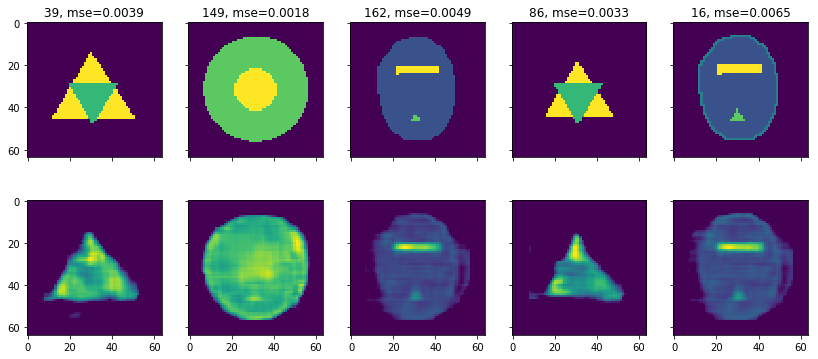

In [24]:
# Visualize Examples
N   = 5
row = 2
col = N

sidx = random.sample(range(len(y_pred)),N)

fig,axs = plt.subplots(row,col,sharex='col',sharey='row',figsize=(14,6))
for i,n in enumerate(sidx):
    axs[0,i%col].imshow(y_test[n])
    axs[1,i%col].imshow(y_pred[n])
    
    mse = mean_squared_error(y_pred[n],y_test[n])
    header = '{0}, mse={1:.04f}'.format(n,mse)
    axs[0,i%col].set_title(header)